<h1>Disaster Tweets Analysis</h1>

In [71]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import string
import unidecode

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, MaxPooling1D, MaxPooling2D, TimeDistributed,Dropout

<h3>Reading the Dataset</h3>

In [5]:
train_tweets_df = pd.read_csv('train.csv')
test_tweets_df = pd.read_csv('test.csv')

<h3>Data Overview</h3>

In [6]:
train_tweets_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [7]:
test_tweets_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<h3>Exploratory Data Analysis</h3>

In [24]:
print("Target Value counts")
print(train_tweets_df['target'].value_counts())

Target Value counts
target
0    4342
1    3271
Name: count, dtype: int64


In [25]:
print("Top 10 categories in Keyword Column")
print(train_tweets_df['keyword'].value_counts()[0:10])

Top 10 categories in Keyword Column
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64


In [26]:
print("Top 10 categories in location Column")
print(train_tweets_df['location'].value_counts()[0:10])

Top 10 categories in location Column
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


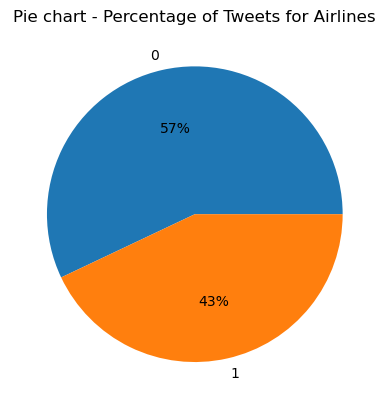

In [14]:
#Percentage of tweets for each airline
total_count = train_tweets_df.shape[0]
tweet_count = train_tweets_df['target'].value_counts().to_dict()
keys = tweet_count.keys()
values = np.fromiter(tweet_count.values(), dtype=int)/total_count

#printing out the pie chart
plt.pie(values, labels = keys, autopct='%.0f%%')
plt.title("Pie chart - Percentage of Tweets for Airlines")
plt.show()

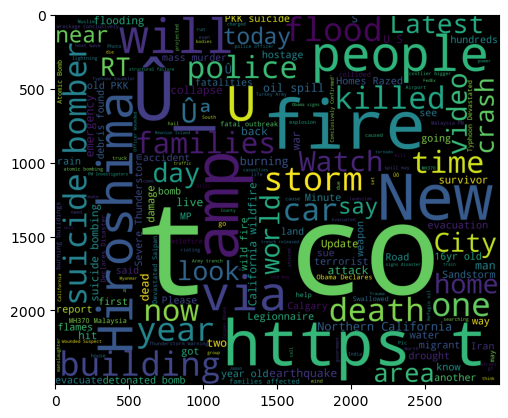

In [21]:
#wordcloud appear for disaster tweets
dis_tweet = train_tweets_df[train_tweets_df['target'] == 1]
totalWords = ' '.join(dis_tweet['text'])
totalCleanWords = " ".join([word for word in totalWords.split()])

wordCloud = WordCloud(stopwords = STOPWORDS,
                      background_color = 'black',
                      width = 3000,
                      height = 2500
                     ).generate(totalCleanWords)
plt.imshow(wordCloud)
plt.show()

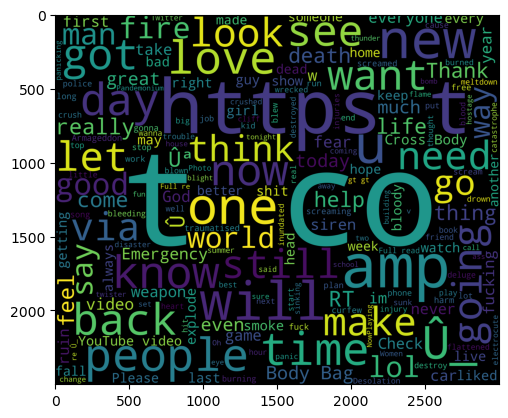

In [27]:
#wordcloud appear for non disaster tweets
non_dis_tweet = train_tweets_df[train_tweets_df['target'] == 0]
totalWords = ' '.join(non_dis_tweet['text'])
totalCleanWords = " ".join([word for word in totalWords.split()])

wordCloud = WordCloud(stopwords = STOPWORDS,
                      background_color = 'black',
                      width = 3000,
                      height = 2500
                     ).generate(totalCleanWords)
plt.imshow(wordCloud)
plt.show()

<h3>Data Handling and Preparation</h3>

In [28]:
#Processing Text
lm = WordNetLemmatizer()

In [29]:
lem_train_list = []
for i in range(train_tweets_df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', train_tweets_df['text'][i])
    review = review.lower()
    review = review.split()
    review = [unidecode.unidecode(word) for word in review]
    review = [lm.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    lem_train_list.append(review)

In [31]:
print(lem_train_list[0:2])

['deed reason earthquake may allah forgive u', 'forest fire near la ronge sask canada']


In [35]:
final_train_tweets_df = {
    'text': lem_train_list,
    'target': train_tweets_df['target'].tolist()
}

In [36]:
final_train_tweets_df = pd.DataFrame(data = final_train_tweets_df)

In [37]:
final_train_tweets_df.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer evacuation shelter place order expected,1
3,people receive wildfire evacuation order california,1
4,got sent photo ruby alaska smoke wildfire pours school,1


<h3>Model Building</h3>

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
Count_vec = CountVectorizer(max_features = 1000)  
data_features = Count_vec.fit_transform(final_train_tweets_df['text'])
data_features = data_features.toarray()  

In [39]:
#Sore Independent and Dependent Variables
X = data_features
y = final_train_tweets_df.target

In [43]:
print(y.shape)

(7613,)


In [44]:
#Split Data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)

In [48]:
# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=100, input_length=X_train.shape[1]))  # Embedding layer
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=6, batch_size=32, steps_per_epoch=50)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/6
50/50 [==============================] - 45s 797ms/step - loss: 0.6854 - accuracy: 0.5806
Epoch 2/6
50/50 [==============================] - 40s 794ms/step - loss: 0.6822 - accuracy: 0.5788
Epoch 3/6
50/50 [==============================] - 41s 826ms/step - loss: 0.6794 - accuracy: 0.5856
Epoch 4/6
50/50 [==============================] - 41s 822ms/step - loss: 0.6819 - accuracy: 0.5762
Epoch 5/6
50/50 [==============================] - 41s 820ms/step - loss: 0.6838 - accuracy: 0.5713
Epoch 6/6
60/60 [==============================] - 7s 110ms/step - loss: 0.6897 - accuracy: 0.5494
Test Accuracy: 0.549369752407074


<h3>Optimizing the Model</h3>

In [50]:
#Intialize TFIDF and use it for vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features = 1000)
data_features = tfidf_vect.fit_transform(final_train_tweets_df['text'])
data_features = data_features.toarray()

In [52]:
#Store Independent and Dependent variables
X = data_features
y = final_train_tweets_df.target

In [53]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)

In [73]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience=3, min_lr=0.001)

In [74]:
#RNN model
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=100, input_length=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 
model.add(LSTM(units=64, return_sequences=True)) 
model.add(Dropout(0.2))  
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=64, activation='relu'))  
model.add(Dropout(0.2)) 
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=6, batch_size=32, steps_per_epoch=50, callbacks=[learning_rate_reduction])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/6
50/50 [==============================] - 50s 859ms/step - loss: 0.6885 - accuracy: 0.5537 - lr: 0.0010
Epoch 2/6
50/50 [==============================] - 44s 885ms/step - loss: 0.6838 - accuracy: 0.5725 - lr: 0.0010
Epoch 3/6
50/50 [==============================] - 45s 896ms/step - loss: 0.6834 - accuracy: 0.5775 - lr: 0.0010
Epoch 4/6
50/50 [==============================] - 45s 900ms/step - loss: 0.6821 - accuracy: 0.5806 - lr: 0.0010
Epoch 5/6
50/50 [==============================] - 44s 881ms/step - loss: 0.6860 - accuracy: 0.5631 - lr: 0.0010
Epoch 6/6
60/60 [==============================] - 20s 303ms/step - loss: 0.6911 - accuracy: 0.5494
Test Accuracy: 0.549369752407074


In [149]:
unit_list = [32, 64, 128]


In [151]:
#RNN model
for i in range(len(unit_list)):
    model = Sequential()
    model.add(Embedding(input_dim=1000, output_dim=100, input_length=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(BatchNormalization()) 
    model.add(LSTM(units=unit_list[i], return_sequences=True)) 
    model.add(Dropout(0.2))  
    model.add(LSTM(units=unit_list[i], return_sequences=False))
    model.add(Dense(units=64, activation='relu'))  
    model.add(Dropout(0.2)) 
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=6, batch_size=32, steps_per_epoch=50, callbacks=[learning_rate_reduction])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Accuracy: units " + str(unit_list[i]), accuracy)

Epoch 1/6
50/50 [==============================] - 40s 668ms/step - loss: 0.6854 - accuracy: 0.5656 - lr: 0.0010
Epoch 2/6
50/50 [==============================] - 33s 656ms/step - loss: 0.6845 - accuracy: 0.5669 - lr: 0.0010
Epoch 3/6
50/50 [==============================] - 33s 663ms/step - loss: 0.6785 - accuracy: 0.5913 - lr: 0.0010
Epoch 4/6
50/50 [==============================] - 32s 644ms/step - loss: 0.6845 - accuracy: 0.5731 - lr: 0.0010
Epoch 5/6
50/50 [==============================] - 32s 639ms/step - loss: 0.6831 - accuracy: 0.5731 - lr: 0.0010
Epoch 6/6
60/60 [==============================] - 13s 199ms/step - loss: 0.6908 - accuracy: 0.5494
Test Accuracy: units 32 0.549369752407074
Epoch 1/6
50/50 [==============================] - 62s 1s/step - loss: 0.6820 - accuracy: 0.5962 - lr: 0.0010
Epoch 2/6
50/50 [==============================] - 53s 1s/step - loss: 0.6834 - accuracy: 0.5838 - lr: 0.0010
Epoch 3/6
50/50 [==============================] - 49s 980ms/step - loss:

In [152]:
lem_test_list = []
for i in range(test_tweets_df.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', test_tweets_df['text'][i])
    review = review.lower()
    review = review.split()
    review = [unidecode.unidecode(word) for word in review]
    review = [lm.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    lem_test_list.append(review)

In [153]:
final_test_tweets_df = {
    'text': lem_test_list,
}

In [154]:
from sklearn.feature_extraction.text import CountVectorizer
Count_vec = CountVectorizer(max_features = 1000)  
data_features = Count_vec.fit_transform(final_test_tweets_df['text'])
data_features = data_features.toarray()  

In [155]:
test_pred = model.predict(data_features)

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000026E9E5C1800>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x0000026E9E5C1800>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Orig

In [160]:
new_test_pred = []
for i in range(len(test_pred)):
    if test_pred[i] >= .5:
        new_test_pred.append(1)
    else:
        new_test_pred.append(0)
new_test_pred[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [164]:
test_pred_df = {
    'id': test_tweets_df['id'].tolist(),
    'target': new_test_pred
}
test_pred_df = pd.DataFrame(data = test_pred_df)
test_pred_df.to_csv("submission.csv", index=False)

<h3>Summary and Analysis</h3>

In this notebook, we explored the application of Recurrent Neural Networks (RNNs) for the task of analyzing disaster-related tweets. We began by preprocessing the dataset, which involved steps like tokenization, lowercasing, and removing stop words. Then, we built an RNN model architecture, incorporating an embedding layer followed by LSTM cells to capture temporal dependencies in the text data.

The success of the RNN model in classifying disaster tweets underscores the effectiveness of deep learning approaches in natural language processing tasks. The model's ability to learn complex patterns and sequential dependencies within text data enables it to capture the nuanced features indicative of disaster-related content.

However, despite the promising performance, there are opportunities for further refinement and enhancement. One potential area for improvement lies in augmenting the dataset with additional labeled examples, particularly instances where the model struggled to generalize effectively. Furthermore, experimenting with different RNN architectures or incorporating attention mechanisms could potentially enhance the model's performance by focusing on salient parts of the input sequence.